In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import shapiro 

from eff.analysis import surprisal, mann_whitney_test, wilcoxon_signed_rank_test
from eff.analysis.plotting import set_lang_ax
from eff.util.util import load_results

np.random.seed(0)

In [2]:
base_path = Path("./out/nelex_unique")
langs_devel = ['fin', 'tur', 'mnc', 'hun', 'khk', 'arb', 'ain', 'ekk', 'hye', 'eus']

In [3]:
ignore_vowel_index = 0

Finnish & 0.002 & 47989 & 0.6033 & 0.4858 \\
Turkish & 0.1538 & 41811 & 0.0098 & 0.429 \\
Manchu & -0.4161 & 88162 & 5.69501783317571e-11 & 0.3573 \\
Normally distributed!, p_value=0.13924969732761383
Hungarian & -0.4427 & 17302 & 1.3181914543434287e-06 & 0.3433 \\
Khalkha Mongolian & 0.2836 & 14083 & 2.4349663835326013e-11 & 0.283 \\
Arabic & -0.3727 & 10983 & 1.8965041000449996e-35 & 0.1397 \\
Ainu & -0.0885 & 24348 & 9.632935695088372e-17 & 0.2677 \\
Estonian & -0.038 & 37992 & 1.0597189487253384e-06 & 0.3678 \\
Armenian & -0.4769 & 13186 & 4.582251752914273e-24 & 0.1953 \\
Basque & -0.148 & 27651 & 1.455503324290604e-48 & 0.1544 \\


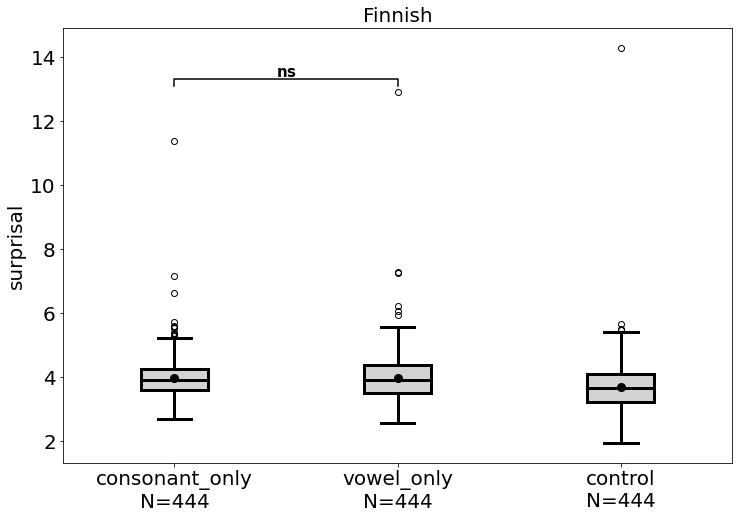

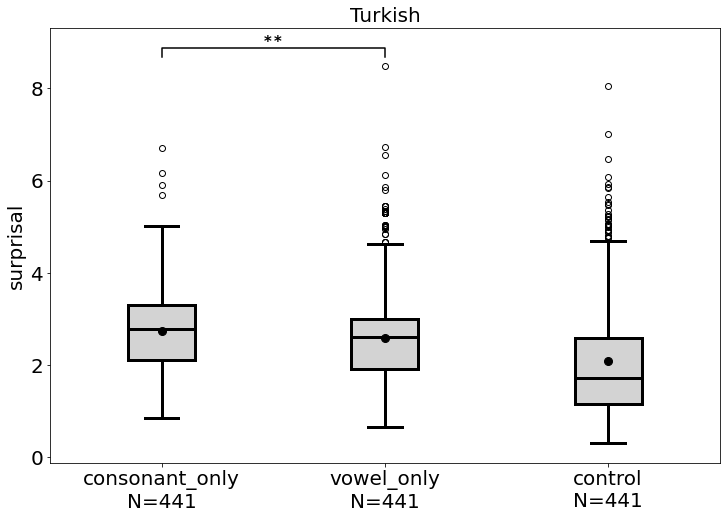

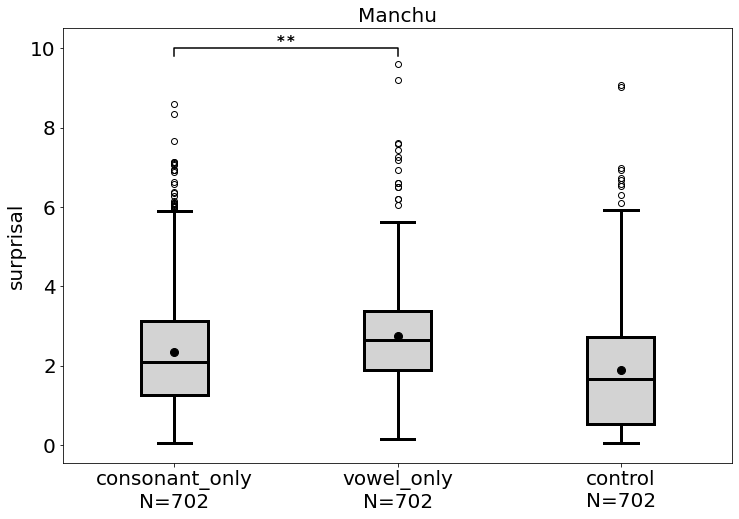

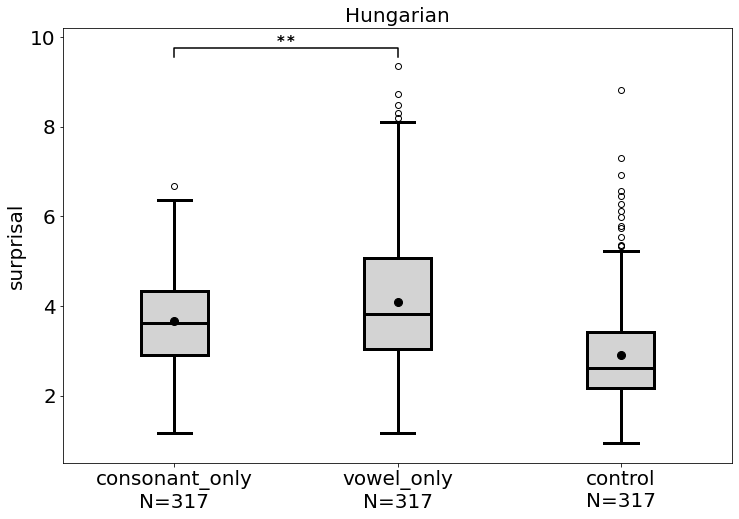

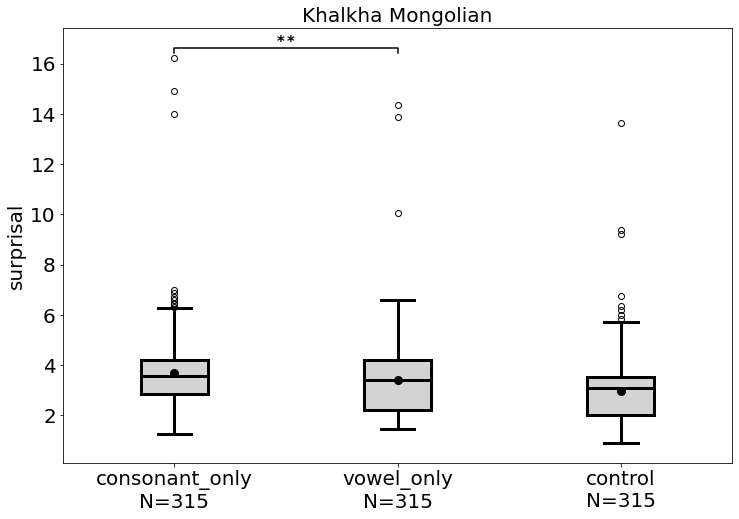

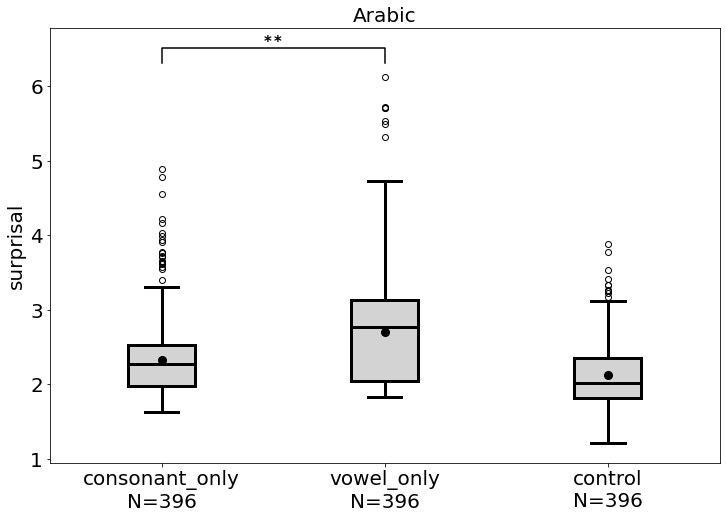

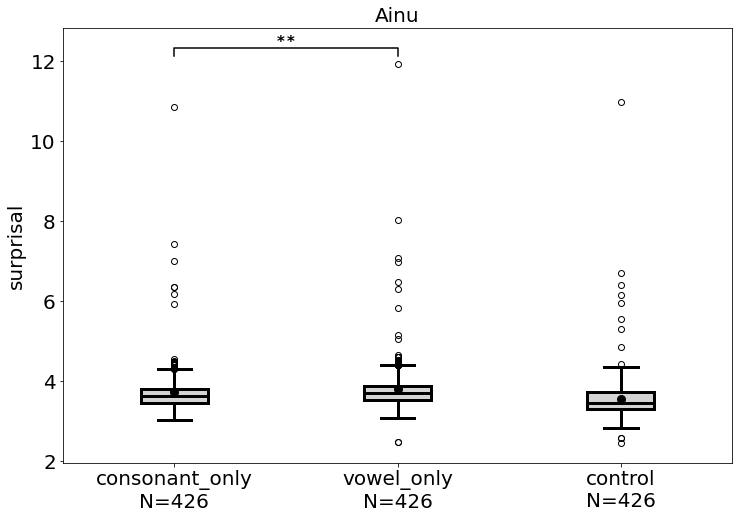

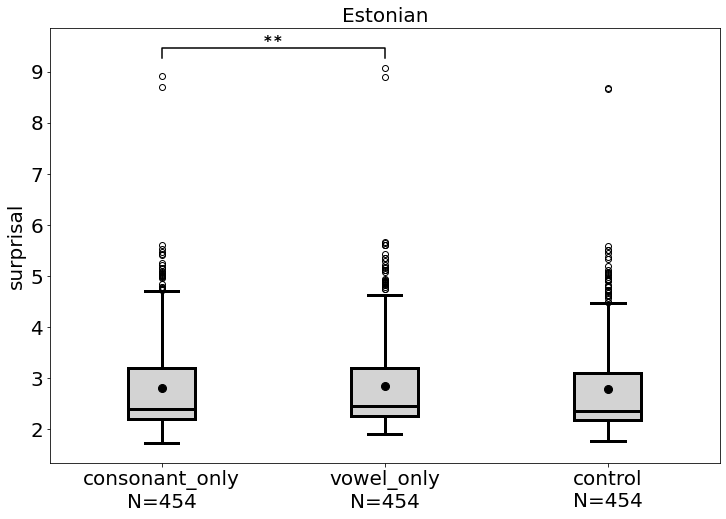

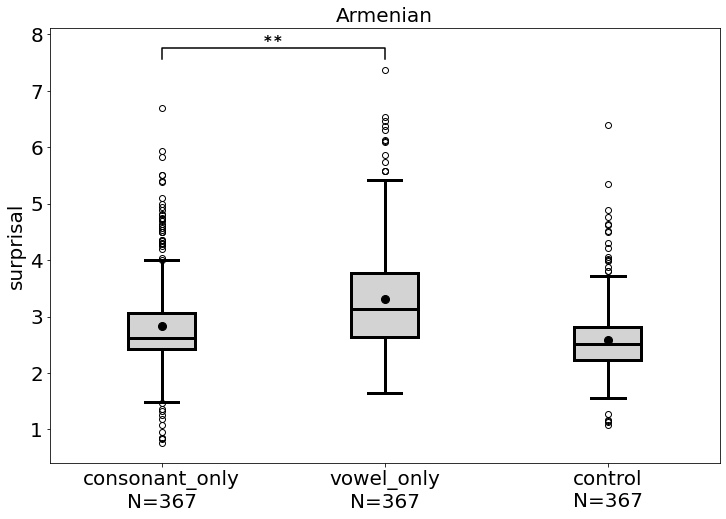

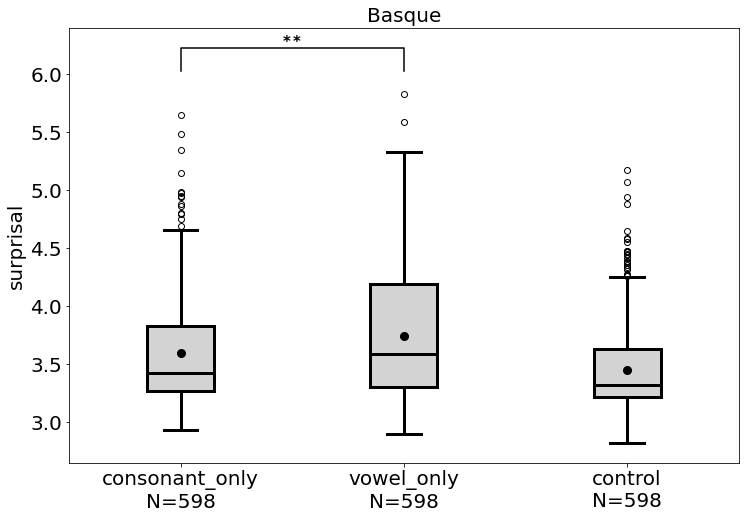

In [4]:
# masking experiment

# fig = plt.figure(figsize=(20, 40))
# fig = plt.figure(figsize=(2*12, 5*8))
# gs = fig.add_gridspec(5, 2, hspace=0.15, wspace=0.25)
# gs = fig.add_gridspec(5, 2, hspace=0.25, wspace=0.25)
# (ax_fin, ax_arb), (ax_tur, ax_ain), (ax_mnc, ax_ekk), (ax_hun, ax_hye), (ax_khk, ax_eus) = gs.subplots()
# (ax_fin, ax_tur, ax_mnc, ax_kor, ax_khk), (ax_ain, ax_arb, ax_ekk, ax_hye, ax_eus) = gs.subplots()

# lang2ax = dict(
#     fin=ax_fin, arb=ax_arb, 
#     tur=ax_tur, ain=ax_ain, 
#     mnc=ax_mnc, ekk=ax_ekk, 
#     hun=ax_hun, hye=ax_hye, 
#     khk=ax_khk, eus=ax_eus
# )

id2name = dict(
    fin="Finnish", arb="Arabic", 
    tur="Turkish", ain="Ainu", 
    mnc="Manchu", ekk="Estonian", 
    hun="Hungarian", hye="Armenian", 
    khk="Khalkha Mongolian", eus="Basque"
)


for lang_id in langs_devel:
    dataset, res, criterion, model = load_results(base_path, lang_id)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
    ax = gs.subplots()
    # ax = lang2ax[lang_id]
    # print("*** {}, N={} ***".format(lang_id.upper(), len(dataset['torch']['unmasked'])))
    # alphabet, bipa = dataset[lang_id]['clts'].output_alphabet, dataset[lang_id]['clts'].bipa
    surprisal_vowel = surprisal(
                        res['vowel_masking']['logprobs'],
                        res['vowel_masking']['targets'],
                        res['vowel_masking']['indices'],
                        ignore_vowel_index=999
                        )
    surprisal_consonant = surprisal(
                            res['consonant_masking']['logprobs'],
                            res['consonant_masking']['targets'],
                            res['consonant_masking']['indices'],
                            ignore_vowel_index=ignore_vowel_index
                            )
    surprisal_none = surprisal(
                        res['unmasked']['logprobs'],
                        res['unmasked']['targets'],
                        res['unmasked']['indices'],
                        ignore_vowel_index=ignore_vowel_index
                        )

    # for s1, s2  in zip(res['vowel_masking']['targets'], res['consonant_masking']['targets']):
    #     print(s1, s2)
    # print(np.mean(surprisal_vowel) - np.mean(surprisal_consonant))

    data = [
        surprisal_vowel, 
        surprisal_consonant, 
        surprisal_none
    ]
    xlabels = [
        "consonant_only\nN={}".format(len(surprisal_vowel)),
        "vowel_only\nN={}".format(len(surprisal_consonant)),
        "control\nN={}".format(len(surprisal_none))
    ]

    set_lang_ax(ax, data, xlabels,
        title=id2name[lang_id],
        boxcolor='lightgrey',
        fontsize=20,
        ylabel="surprisal"
    )

    # print("Consonants-only\t", round(shapiro(surprisal_vowel)[1], 8))
    # print("Vowels-only\t", round(shapiro(surprisal_consonant)[1], 8))
    # print("Control\t\t", round(shapiro(surprisal_none)[1], 8))
    for cond in [surprisal_consonant, surprisal_vowel, surprisal_none]:
        W, p_value = shapiro(cond)
        if p_value > 1e-4:
            print("Normally distributed!, p_value={}".format(p_value))

    delta_mean = np.mean(surprisal_vowel)-np.mean(surprisal_consonant)

    U, p_value, r = wilcoxon_signed_rank_test(surprisal_vowel, surprisal_consonant)
    # print("Statistic: {}\t p-value: {}\t Effect Size: {}".format(U, p_value, r))
    # print("Delta mean = {}".format(np.mean(surprisal_vowel)-np.mean(surprisal_consonant)))

    print("{} & {} & {} & {} & {} \\\\".format(
        id2name[lang_id],
        round(delta_mean, 4),
        int(U),
        p_value if p_value < 1e-4 else round(p_value, 4),
        round(r, 4)
    ))

    significane_level = None
    if p_value < 0.01:
        significane_level = r"$\bf{**}$"
    elif p_value < 0.05:
        significane_level = r"$\bf{*}$"
    else:
        significane_level = r"$\bf{ns}$"
    

    x1, x2 = 1, 2
    y, h, col = max(surprisal_vowel+surprisal_consonant) + 0.2, 0.2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h,  significane_level, ha='center', va='bottom', color=col, fontsize=15)

    plt.yticks(fontsize=20)


    plt.savefig("../img/surprisal_VCE_{}.png".format(lang_id),
                bbox_inches='tight',
                pad_inches=0,
                format='png',
                dpi=300)

In [5]:
# Now for wiktionary data
# base_path = Path("./out/wikt_unique")
# dataset, res, criterion, model = load_results(base_path)

In [6]:

# plt.rc('ytick', labelsize=15)
# plt.rc('xtick', labelsize=15)

# # fig = plt.figure(figsize=(20, 40))
# fig = plt.figure(figsize=(32, 24))
# gs = fig.add_gridspec(2, 2, hspace=0.15, wspace=0.25)
# (ax_fin, ax_tur), (ax_hye, ax_arb) = gs.subplots()

# lang2ax = dict(
#     fin=ax_fin, tur=ax_tur,
#     hye=ax_hye, arb=ax_arb
# )

# for lang_id in res:
#     ax = lang2ax[lang_id]
#     # alphabet, bipa = dataset[lang_id]['clts'].output_alphabet, dataset[lang_id]['clts'].bipa
#     surprisal_vowel = surprisal(
#                         res[lang_id]['vowel_masking']['logprobs'],
#                         res[lang_id]['vowel_masking']['targets'],
#                         res[lang_id]['vowel_masking']['indices'],
#                         ignore_vowel_index=999  
#                         )
#     surprisal_consonant = surprisal(
#                             res[lang_id]['consonant_masking']['logprobs'],
#                             res[lang_id]['consonant_masking']['targets'],
#                             res[lang_id]['consonant_masking']['indices'],
#                             ignore_vowel_index=ignore_vowel_index
#                             )
#     surprisal_none = surprisal(
#                         res[lang_id]['unmasked']['logprobs'],
#                         res[lang_id]['unmasked']['targets'],
#                         res[lang_id]['unmasked']['indices'],
#                         ignore_vowel_index=ignore_vowel_index
#                         )
#     # mwu_vc = mannwhitneyu(surprisal_vowel, surprisal_consonant)
#     # mwu_ec = mannwhitneyu(surprisal_consonant, surprisal_none)
#     # print(mwu_vc)
#     # print(mwu_ec)
#     data = [surprisal_vowel, surprisal_consonant, surprisal_none]
#     bp = ax.boxplot(data, patch_artist=True, showmeans=True)
#     for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#         plt.setp(bp[element], color='black')
#     plt.setp(bp['medians'], color='red')
#     for box in bp['boxes']:
#         # box.set(color='red', linewidth=1)
#         box.set(facecolor='#929591')
#         # box.set(hatch = '/')

#     ax.set_xticklabels(["V", "C", "E"])
#     ax.set_title(lang_id, fontsize=15)
#     # ax.set_ylabel("Surprisal on vowels")

#     for xtick in range(len(data)):
#         median = round(np.median(data[xtick]), 2)
#         ax.text(xtick+1.2, median*0.95, median, fontsize=15)
#         mean = round(np.mean(data[xtick]), 2)
#         ax.text(xtick+0.6, mean*0.95, mean, fontsize=12)

#     stats = test_statistics(dict(
#         V=surprisal_vowel,
#         C=surprisal_consonant,
#         E=surprisal_none
#     ))
#     print(lang_id, stats)

# plt.savefig("../img/surprisal_VCE_wikt.png",
#             bbox_inches='tight',
#             pad_inches=0,
#             format='png',
#             dpi=300)

# plt.show()
